#### using transfer learning for the segementation job

In [2]:
# data loading 

import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import os
import pandas as pd
import random

In [3]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
data_ids = next(os.walk(DATA_PATH))[1]
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]E:\INSTALL\anaconda\envs\seg\lib\site-packages\mrcfile\mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  5.88it/s]

tomo1_focalseries.mrc
tomo2_focalseries.mrc
tomo3_focalseries.mrc


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.93it/s]

tomo1_groundtruth.mrc
tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s]


In [4]:
# raw data sorting: padding, reshape

import torchio as tio
from patchify import patchify, unpatchify

# training dataset raw
train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]

trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512  # padding into the same size
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];

(512, 256, 256)
(512, 256, 256)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [5]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [6]:
# train dataset
patchPara = {'x': 256, 'y': 256, 'step':256}
Xtrain_patches, _ = rawPatch(train_padd, patchPara);Xtrain_patches = np.stack((Xtrain_patches,)*3, axis=-1) # dock 3 times, the model expects 3 channel
# print(Xtrain_patches.shape)

Ytrain_patches, _ = rawPatch(label, patchPara);Ytrain_patches = np.expand_dims(Ytrain_patches, -1)
Ytrain_patches = (Ytrain_patches > 0.5).astype(np.float) # binarize the data

# test dataset
Xtest_patches, patchSize = rawPatch(test_padd, patchPara);Xtest_patches = np.stack((Xtest_patches,)*3, axis=-1)
Ytest_patches, _ = rawPatch(Y_test_label, patchPara);Ytest_patches = np.expand_dims(Ytest_patches, -1)
Ytest_patches = (Ytest_patches > 0.5).astype(np.float)
print(Xtest_patches.shape);print(Ytest_patches.shape)

E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


(256, 256, 256, 3)
(256, 256, 256, 1)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [7]:
# usinng pre-trained weight

import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [8]:
# preprocessing the data

# preprocess input
images = Xtrain_patches; masks = Ytrain_patches;
images1=preprocess_input1(images)
print(images1.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)


(512, 256, 256, 3)
(384, 256, 256, 3)
(128, 256, 256, 3)


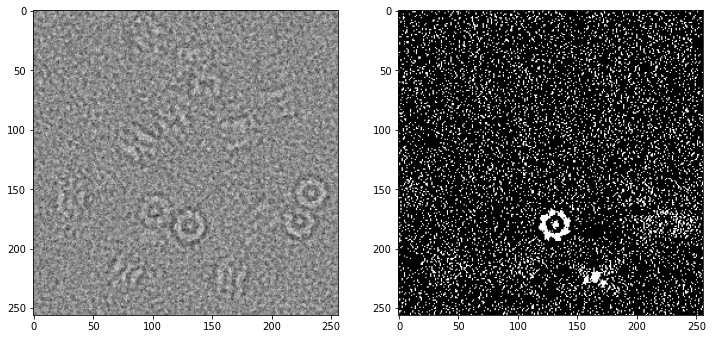

In [10]:
#Sanity check, view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [12]:
# data generator

seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

In [13]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [14]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

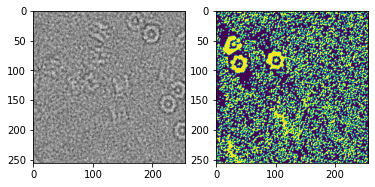

In [15]:
# sanity check

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [17]:
# define model

import segmentation_models as sm

sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
print(model.summary())




85532672/85521592 [==============================] - 33s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                      

                                                                                                  
 add_17 (Add)                   (None, None, None,   0           ['stage1_unit2_conv2[0][0]',     
                                64)                               'add_16[0][0]']                 
                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_17[0][0]']                 
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padd

                                128)                                                              
                                                                                                  
 add_20 (Add)                   (None, None, None,   0           ['stage2_unit2_conv2[0][0]',     
                                128)                              'add_19[0][0]']                 
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_20[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
          

 stage3_unit1_sc (Conv2D)       (None, None, None,   32768       ['stage3_unit1_relu1[0][0]']     
                                256)                                                              
                                                                                                  
 add_23 (Add)                   (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_23[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )        

                                                                                                  
 add_26 (Add)                   (None, None, None,   0           ['stage3_unit4_conv2[0][0]',     
                                256)                              'add_25[0][0]']                 
                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_26[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padd

                                512)                                                              
                                                                                                  
 add_29 (Add)                   (None, None, None,   0           ['stage4_unit1_conv2[0][0]',     
                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_29[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
          

                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0b_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0b_relu (Activati  (None, None, None,   0          ['decoder_stage0b_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage1_upsampling (UpS  (None, None, None,   0          ['decoder_stage0b_relu[0][0]']   
 ampling2D)                     256)                                                              
                                                                                                  
 decoder_s

 ampling2D)                     32)                                                               
                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, None, None,   4608        ['decoder_stage4_upsampling[0][0]
                                16)                              ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, None, None,   64         ['decoder_stage4a_conv[0][0]']   
 lization)                      16)                                                               
                                                                                                  
 decoder_stage4a_relu (Activati  (None, None, None,   0          ['decoder_stage4a_bn[0][0]']     
 on)                            16)                                                               
          

NameError: name 'k' is not defined

In [ ]:
#Fit the model and train

import tensorflow.keras as k
callbacks = [
    k.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = 'logsTransfer')
]

history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50, callbacks= callbacks)

Epoch 1/50


In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# prediction IOU

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()
